# Análise dataset Olist

Você é o responsável pela análise que servirá para a estratégia de de uma grande varejista.

Elabore uma apresentação para os investidores desta empresa:

## Preparação do ambiente

### Importação das bibliotecas nececcárias para análise dos dados

In [90]:
# Bibliotecas para manipulação dos dados
import numpy as np
import pandas as pd

# Biblotecas para geração de gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para agrupamento
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

# Bibliotecas para classificação
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# Bibliotecas para séries temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series

%matplotlib inline

### Leitura dos dados

In [91]:
vendas = pd.read_csv('./archive/olist_orders_dataset.csv')
pagamentos_venda = pd.read_csv('./archive/olist_order_payments_dataset.csv')
itens_venda = pd.read_csv('./archive/olist_order_items_dataset.csv')
produtos = pd.read_csv('./archive/olist_products_dataset.csv')
clientes = pd.read_csv('./archive/olist_customers_dataset.csv') 

### União dos DataFrames e seleção de colunas de interesse

Visualização das colunas de cada DataFrame

In [92]:
print(vendas.columns)
print(pagamentos_venda.columns)
print(itens_venda.columns)
print(produtos.columns)
print(clientes.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


O primeiro passo será realizar a união dos DataFrames `vendas` e `pagamentos_venda`. Como critério de união será utilizado o `order_id` que é a variável comum aos dois DataFrames. Para a tabela resultante serão selecionadas as colunas: 'customer_id', 'order_status', 'order_approved_at', 'payment_type', 'payment_value'.

In [93]:
vendas_pgtos = vendas.set_index('order_id').join(pagamentos_venda.set_index('order_id'), how='inner')
vendas_pgtos = vendas_pgtos[['customer_id', 'order_status', 'order_approved_at', 'payment_type', 'payment_value']]

O próximo passo é a união da `vendas_pgtos` com `itens_vendas` novamente o critério de união será `order_id`. As colunas de interesse são: 'customer_id', 'order_status', 'order_approved_at', 'payment_type', 'payment_value', 'product_id', 'price', 'freight_value'.

In [94]:
vendas_pgtos_item = vendas_pgtos.join(itens_venda.set_index('order_id'))
vendas_pgtos_item = vendas_pgtos_item[['customer_id', 'order_status', 'order_approved_at', 'payment_type', 'payment_value',
                                       'product_id', 'price', 'freight_value']]
vendas_pgtos_item = vendas_pgtos_item.reset_index()

Em seguinda a união de `vendas_pgtos_item` com `produtos` para gerar o novo DataFrame de `vendas`. O critério de união é `product_id` e as colunas de interesse são: 'customer_id', 'order_id', 'order_status', 'order_approved_at', 'payment_type', 'payment_value' 'price', 'freight_value', 'product_category_name'

In [95]:
vendas = vendas_pgtos_item.set_index('product_id').join(produtos.set_index('product_id'), how='inner')
vendas = vendas[['customer_id', 'order_id', 'order_status', 'order_approved_at', 'payment_type', 'payment_value',
                 'price', 'freight_value', 'product_category_name']].reset_index()
vendas.head()

,product_id,customer_id,order_id,order_status,order_approved_at,payment_type,payment_value,price,freight_value,product_category_name
0,00066f42aeeb9f3007548bb9d3f33c38,86c180c33f454b35e1596a99da3dddc4,f30149f4a8882a08895b6a242aa0d612,delivered,2018-05-20 18:58:59,credit_card,120.24,101.65,18.59,perfumaria
1,00088930e925c41fd95ebfe695fd2655,68f2b37558e27791155db34bcded5ac0,f5eda0ded77c1293b04c953138c8331d,delivered,2017-12-12 19:32:19,credit_card,143.83,129.90,13.93,automotivo
2,0009406fd7479715e4bef61dd91f2462,6cd217b674e22cf568f6a2cf6060fd07,0bf736fd0fd5169d60de3699fcbcf986,delivered,2017-12-22 17:31:27,credit_card,242.10,229.00,13.10,cama_mesa_banho
3,000b8f95fcb9e0096488278317764d19,82b838f513e00463174cc7cae7e76c1f,3aba44d8e554ab4bb8c09f6f78032ca8,delivered,2018-08-10 13:35:21,credit_card,78.50,58.90,19.60,utilidades_domesticas
4,000b8f95fcb9e0096488278317764d19,8517e7c86998bf39a540087da6f115d9,6f0dfb5b5398b271cc6bbd9ee263530e,delivered,2018-08-01 22:15:19,credit_card,78.50,58.90,19.60,utilidades_domesticas


A última etapa deste processamento é a união de `vendas` com `clientes`. O critério de união é a coluna `customer_id` e as colunas de interesse são: 'customer_id', 'order_id', 'product_id', 'customer_state', 'order_status', 'order_approved_at', 'payment_type', 'payment_value', 'product_category_name'

In [96]:
vendas_clientes = clientes.set_index('customer_id').join(vendas.set_index('customer_id')).dropna().reset_index()
vendas_clientes = vendas_clientes[['customer_id', 'order_id', 'product_id', 'customer_state', 'order_status',
                                   'order_approved_at', 'payment_type', 'payment_value', 'product_category_name']]
vendas_clientes.head()

,customer_id,order_id,product_id,customer_state,order_status,order_approved_at,payment_type,payment_value,product_category_name
0,00012a2ce6f8dcda20d059ce98491703,5f79b5b0931d63f1a42989eb65b9da6e,64315bd8c0c47303179dd2e25b579d00,SP,delivered,2017-11-14 16:35:32,credit_card,114.74,brinquedos
1,000161a058600d5901f007fab4c27140,a44895d095d7e0702b6a162fa2dbeced,84183944dc7cddca87a5d384452c1d3c,MG,delivered,2017-07-16 09:55:12,credit_card,67.41,beleza_saude
2,0001fd6190edaaf884bcaf3d49edf079,316a104623542e4d75189bb372bc5f8d,9df2b21ec85378d71df4404712e17478,ES,delivered,2017-02-28 11:15:20,credit_card,195.42,bebes
3,0002414f95344307404f0ace7a26f1d5,5825ce2e88d5346438686b0bba99e5ee,af3ec22cce878225aae6d9eb6c7a78eb,MG,delivered,2017-08-17 03:10:27,boleto,179.35,cool_stuff
4,000379cdec625522490c315e70c7a9fb,0ab7fb08086d4af9141453c91878ed7a,868b3136c5b206f91b8208fbfdf2cb7c,SP,delivered,2018-04-04 03:10:19,boleto,107.01,cama_mesa_banho


In [97]:
vendas_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115889 entries, 0 to 115888
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            115889 non-null  object 
 1   order_id               115889 non-null  object 
 2   product_id             115889 non-null  object 
 3   customer_state         115889 non-null  object 
 4   order_status           115889 non-null  object 
 5   order_approved_at      115889 non-null  object 
 6   payment_type           115889 non-null  object 
 7   payment_value          115889 non-null  float64
 8   product_category_name  115889 non-null  object 
dtypes: float64(1), object(8)
memory usage: 8.0+ MB


Não há valores nulos

## Funções auxiliares

### groupby

Esta função agrupa e ordena um dataframe de acordo com os critérios informados.

In [98]:
def groupby(dados, coluna_groupby, coluna_valores, n_top=10, ascending=False, agg_fun='sum'):
    '''
    Agrupa os dados de acordo com os critérios informados.
    
    Inputs:
        dados: Dataframe a ser agrupado e ordenado.
        coluna_groupby: Nome da coluna que será utilizada para agrupar os dados
        coluna_valores: Coluna com valores onde será aplicada a função de agregação. 
                        Também é utilizada para ordenar os dados de saída.
        n_top: Número de linhas do dataframe de saída. Caso não seja informado retorna todas as linhas.
        ascending: True ou False. Se True ordena a saída em ordem crescente, caso contrário ordena em ordem descendente.
        agg_fun: Função de agregação: Exemplos: sum, mean, std, count.
    
    Output:
        grupo: dataframe com os dados agrupados e ordenados.
    '''
    grupo = dados.groupby(coluna_groupby)[coluna_valores].agg(agg_fun).to_frame()
    grupo = grupo.sort_values(by=coluna_valores, ascending=ascending)
    if n_top:
        grupo = grupo.head(n_top)
    return grupo

### plot_bars

Função para plotar gráficos de barras.

In [99]:
def plot_bars(dados, y, x, color='#fe0000', title='', xlabel='', ylabel='', figsize=(10, 6), fontsize_title=18,
              xlim=False):
    plt.figure(figsize=figsize, dpi=150)
    fig = sns.barplot(data=dados, y=y, x=x, color='#fe0000', orient='h')
    plt.ylabel(ylabel)
    plt.title(title, fontsize=fontsize_title, style='italic')
    plt.xlabel(xlabel, fontsize=12)
    
    if xlim:
        plt.xlim(xlim)
    
    fig.spines[['top', 'right']].set_visible(False)
    plt.show()

## Análise descritiva

### Quantidade de clientes há estratificado por estado.

In [100]:
clientes_por_estado = groupby(clientes, 'customer_state', 'customer_id', agg_fun='count', n_top=False)
clientes_por_estado

,customer_id
customer_state,
SP,41746
RJ,12852
MG,11635
RS,5466
PR,5045
SC,3637
BA,3380
DF,2140
ES,2033


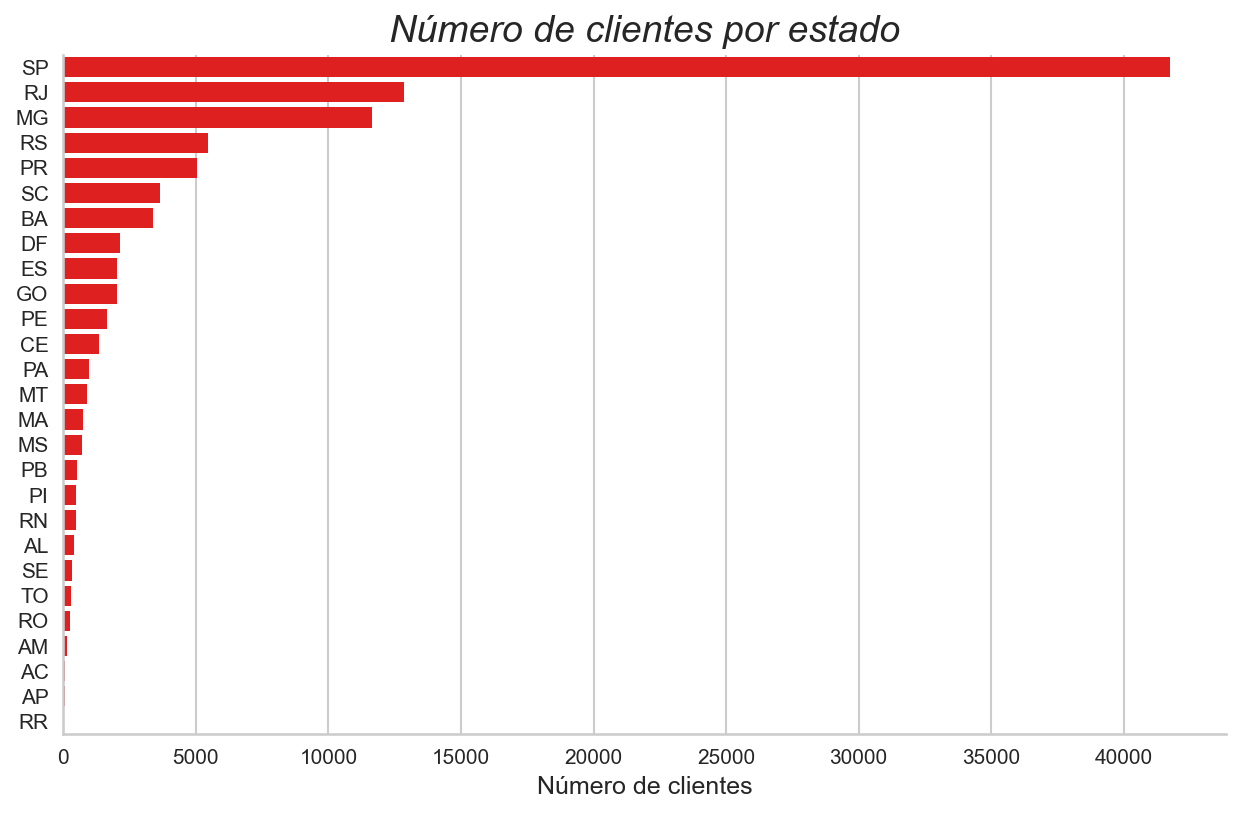

In [101]:
plot_bars(clientes_por_estado, x='customer_id', y=clientes_por_estado.index,
          title='Número de clientes por estado',
          xlabel='Número de clientes')

### Quais as 10 categorias de produto com o maior volume de vendas?

In [102]:
vendas_categoria_volume = groupby(vendas, 'product_category_name', 'product_id', agg_fun='count')
vendas_categoria_volume

,product_id
product_category_name,
cama_mesa_banho,11823
beleza_saude,9972
esporte_lazer,8945
moveis_decoracao,8744
informatica_acessorios,8082
utilidades_domesticas,7355
relogios_presentes,6201
telefonia,4721
ferramentas_jardim,4574


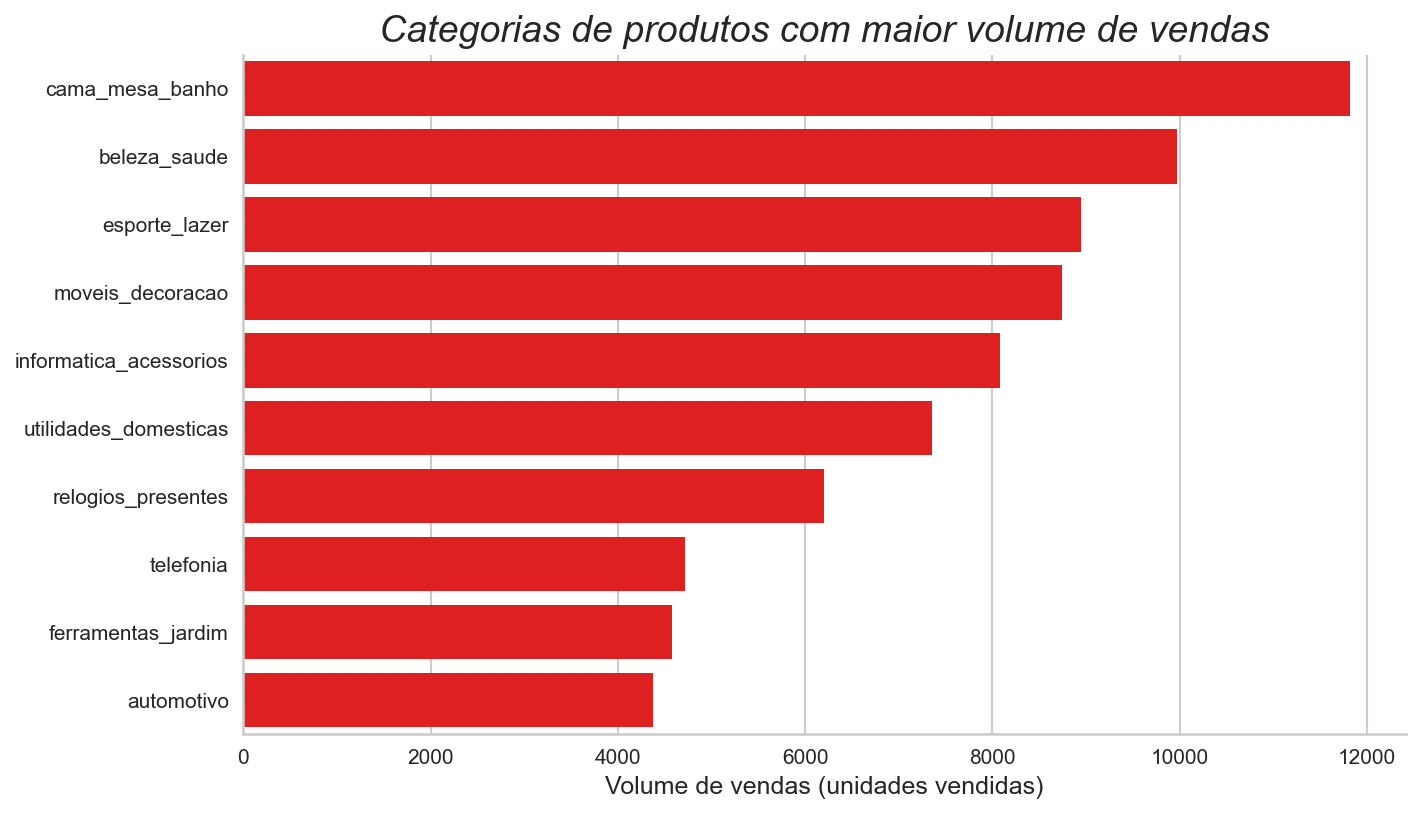

In [103]:
plot_bars(vendas_categoria_volume, x='product_id', y=vendas_categoria_volume.index,
          title='Categorias de produtos com maior volume de vendas',
          xlabel='Volume de vendas (unidades vendidas)')

### Quais as categorias de produto com maior receita?

In [104]:
vendas_categoria_receita = groupby(vendas, 'product_category_name', 'payment_value', agg_fun='sum') / 1_000_000
vendas_categoria_receita

,payment_value
product_category_name,
cama_mesa_banho,1.712554
beleza_saude,1.657373
informatica_acessorios,1.585330
moveis_decoracao,1.430176
relogios_presentes,1.429217
esporte_lazer,1.392128
utilidades_domesticas,1.094758
automotivo,0.852294
ferramentas_jardim,0.838281


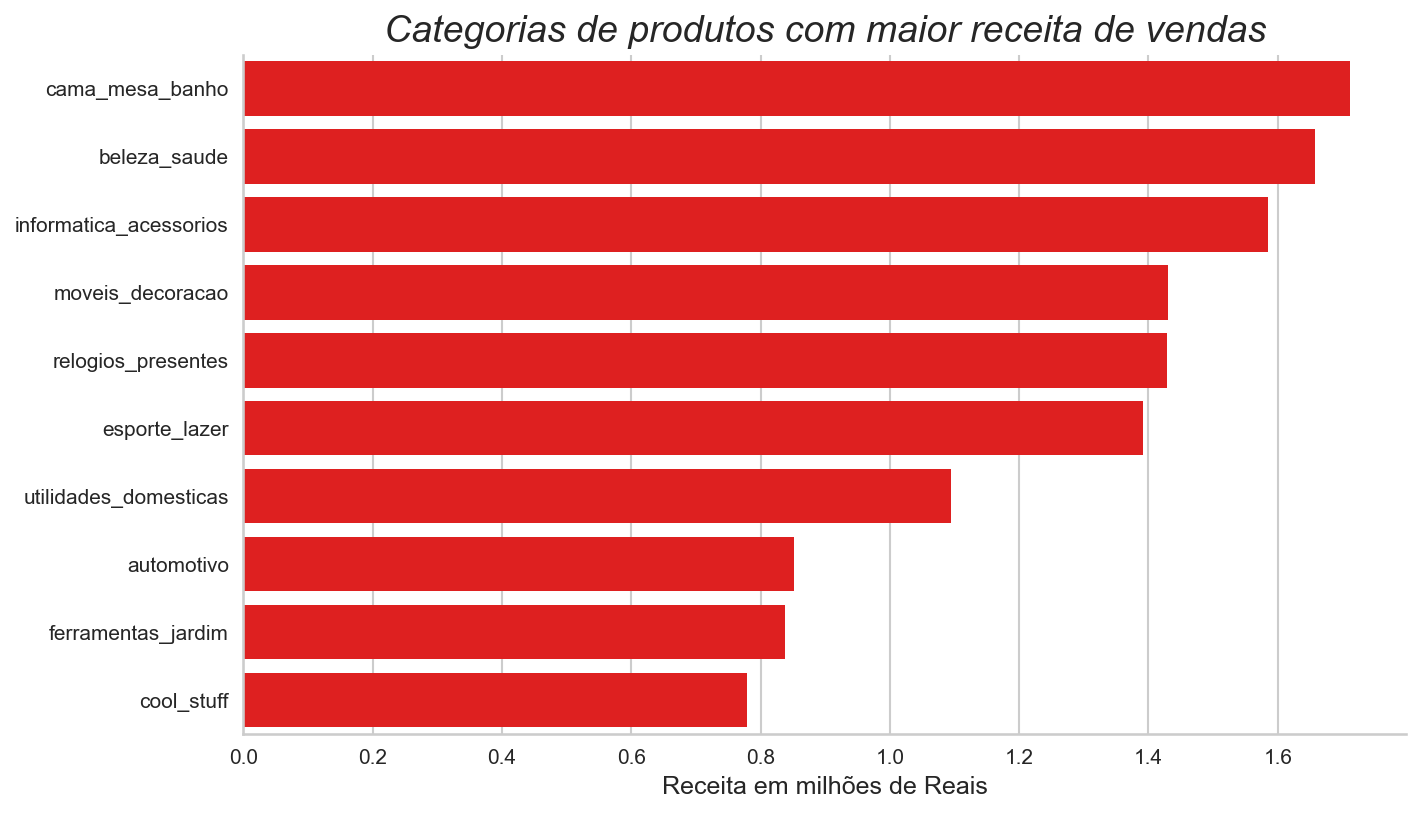

In [105]:
plot_bars(vendas_categoria_receita, x='payment_value', y=vendas_categoria_receita.index,
          title='Categorias de produtos com maior receita de vendas',
          xlabel='Receita em milhões de Reais')

### Vendas por método de pagamento

In [106]:
vendas_metodo_pagamento = groupby(vendas, 'payment_type', 'payment_value', agg_fun='sum') / 1_000_000
vendas_metodo_pagamento

,payment_value
payment_type,
credit_card,15.589028
boleto,4.059700
voucher,0.405873
debit_card,0.253534


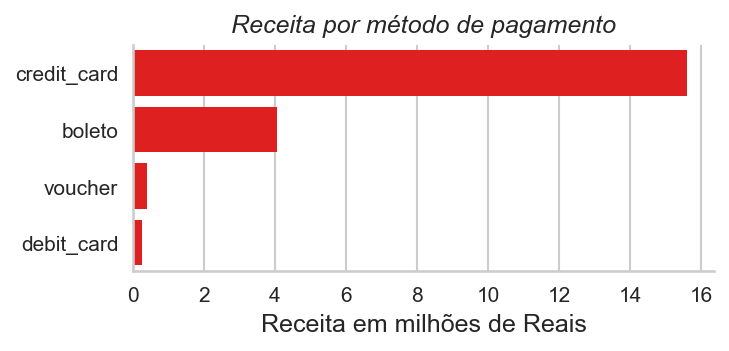

In [107]:
plot_bars(vendas_metodo_pagamento, x='payment_value', y=vendas_metodo_pagamento.index,
          title='Receita por método de pagamento',
          xlabel='Receita em milhões de Reais',
          figsize=(5, 2), fontsize_title=12)

In [108]:
colors = ['#fe0000', '#eb661b', '#f18813', '#f6a150', '#fcd12a']

## Agrupamento dos clientes
Classifique os clientes com as informações disponíveis (utilize um algoritmo de cluster, se julgar necessário). Caracterize os grupos de cliente criado da melhor maneira possível.

## K-MEANS

In [109]:
le = OrdinalEncoder()
scaler = MinMaxScaler()

clientes_kmeans = vendas_clientes[['customer_state', 'payment_type', 'payment_value', 'product_category_name']]

clientes_kmeans[['customer_state', 'payment_type', 'product_category_name']] = le.fit_transform(clientes_kmeans[['customer_state',
                                                                                                                'payment_type',
                                                                                                                'product_category_name']])
clientes_kmeans_scaled = clientes_kmeans.copy()
clientes_kmeans_scaled = scaler.fit_transform(clientes_kmeans)
clientes_kmeans_scaled = pd.DataFrame(clientes_kmeans_scaled, columns=clientes_kmeans.columns)
clientes_kmeans_scaled.head()

C:\Users\duart\miniconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,customer_state,payment_type,payment_value,product_category_name
0,0.961538,0.333333,0.008397,0.166667
1,0.384615,0.333333,0.004933,0.152778
2,0.269231,0.333333,0.014302,0.125000
3,0.384615,0.000000,0.013126,0.361111
4,0.961538,0.000000,0.007831,0.180556


Teste do cotovelo para determinação do número ideal de cluesters.

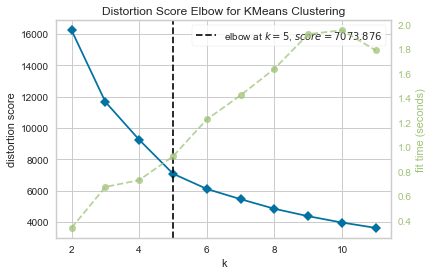

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [110]:
modelo = KMeans()
visualizer = KElbowVisualizer(modelo, k=(2, 12))
visualizer.fit(clientes_kmeans_scaled)
visualizer.show()

Implementação do K-means

In [111]:
kmeans = KMeans(n_clusters=5, random_state=101)
kmeans.fit(clientes_kmeans_scaled)
clusters = kmeans.predict(clientes_kmeans_scaled)
clientes_kmeans_scaled['cluster'] = clusters

columns = clientes_kmeans.columns
clientes_kmeans_coded = clientes_kmeans_scaled.copy()
clientes_kmeans_scaled[columns] = pd.DataFrame(scaler.inverse_transform(clientes_kmeans_scaled[columns]),
                                    columns=columns)
clientes_kmeans_scaled[['customer_state', 'payment_type', 'product_category_name']] = le.inverse_transform(clientes_kmeans_scaled[['customer_state', 'payment_type', 'product_category_name']])


Características dos clusters

Volumes e receitas acumulados por cluster

In [112]:
clientes_kmeans_scaled

,customer_state,payment_type,payment_value,product_category_name,cluster
0,SP,credit_card,114.74,brinquedos,2
1,MG,credit_card,67.41,beleza_saude,1
2,ES,credit_card,195.42,bebes,1
3,MG,boleto,179.35,cool_stuff,1
4,SP,boleto,107.01,cama_mesa_banho,2
...,...,...,...,...,...
115884,RS,voucher,71.23,cama_mesa_banho,4
115885,RJ,credit_card,63.13,telefonia,0
115886,SP,credit_card,214.13,cama_mesa_banho,2
115887,MG,credit_card,45.50,moveis_decoracao,3


In [113]:
pt1 = clientes_kmeans_scaled.groupby('cluster')['payment_value'].mean()
pt1

cluster
0    184.065143
1    188.705962
2    160.576042
3    208.102621
4     69.692914
Name: payment_value, dtype: float64

In [114]:
def plot_clusters(coluna, title='', n_clusters=5, n_top=10):
    for cluster in range(n_clusters):
        clientes_cluster = clientes_kmeans_scaled.query(f'cluster == {cluster}')
        clientes_cluster = groupby(clientes_cluster, coluna, 'cluster', agg_fun='count', n_top=n_top) / len(clientes_cluster)
        clientes_cluster *= 100
        plot_bars(clientes_cluster, x='cluster', y=clientes_cluster.index,
            title=f'{title} cluster: {cluster}',
            xlabel='Porcentagem de clientes (%)',
            figsize=(5, 2), fontsize_title=12, xlim=(0, 100))
        plt.show()

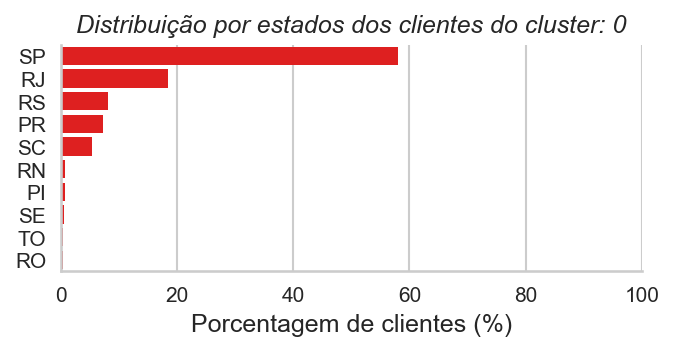

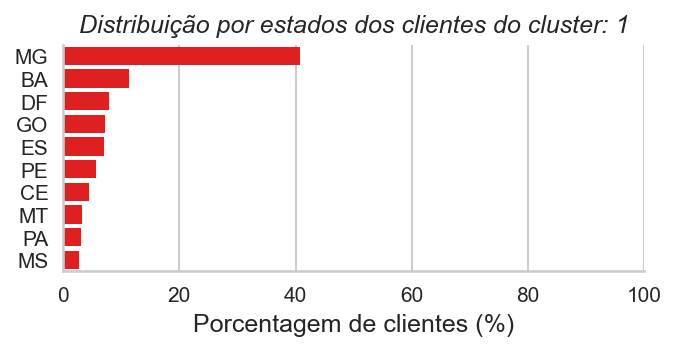

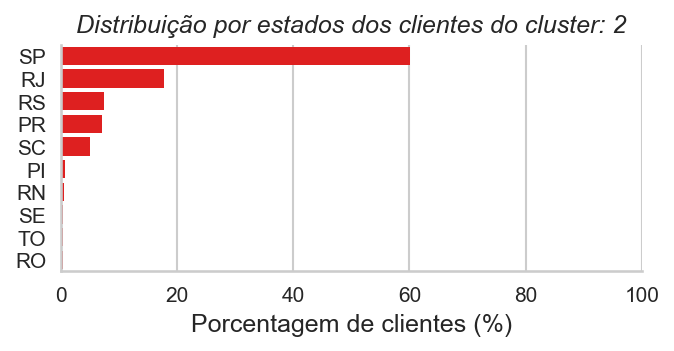

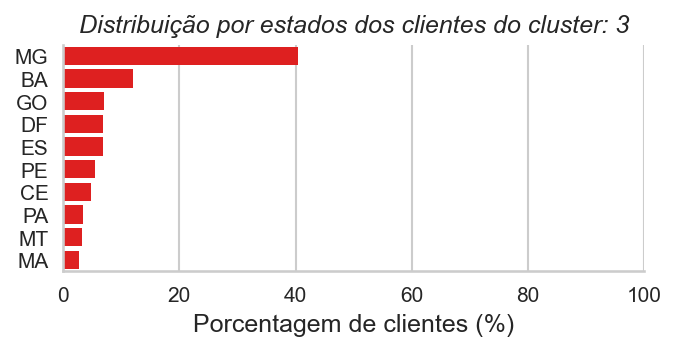

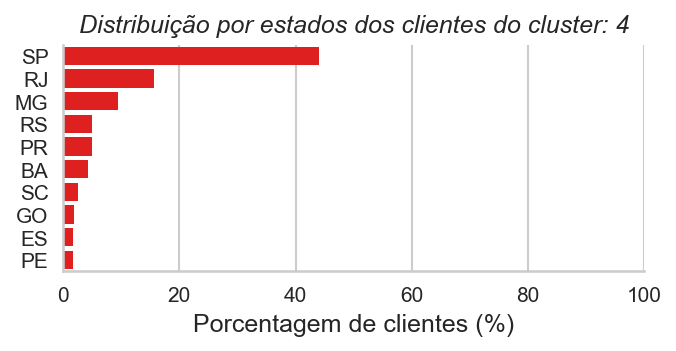

In [115]:
plot_clusters('customer_state', title='Distribuição por estados dos clientes do')

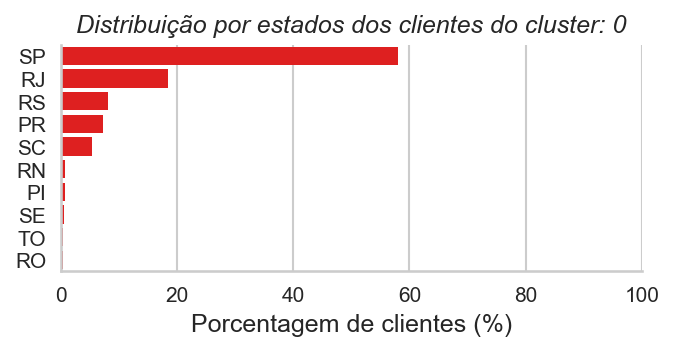

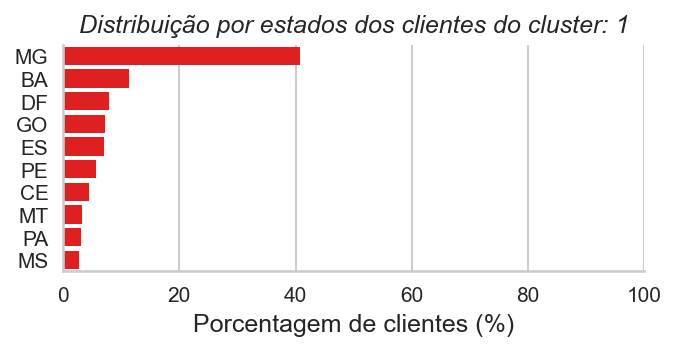

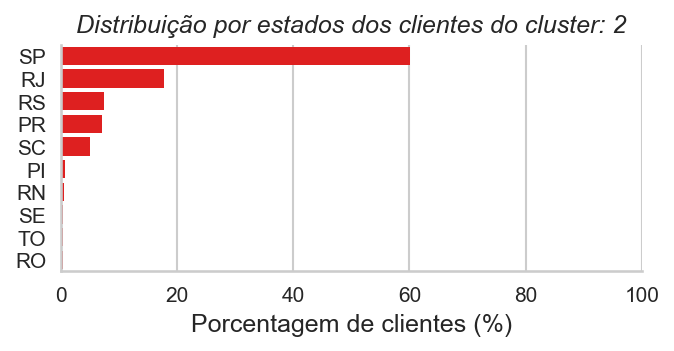

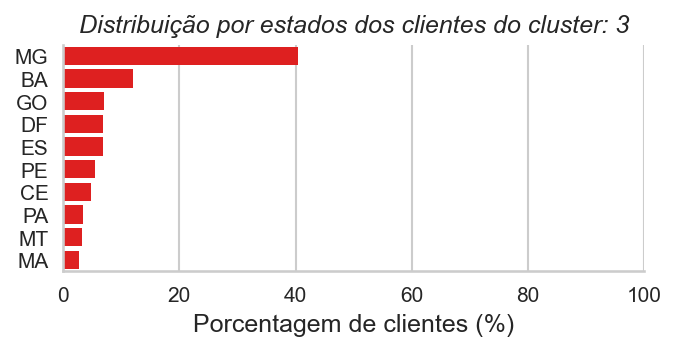

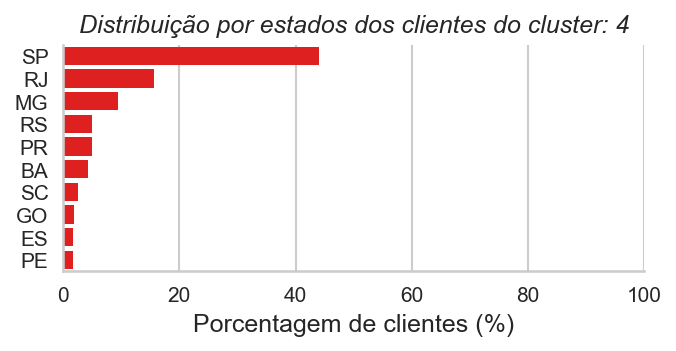

In [116]:
plot_clusters('customer_state', title='Distribuição por estados dos clientes do')

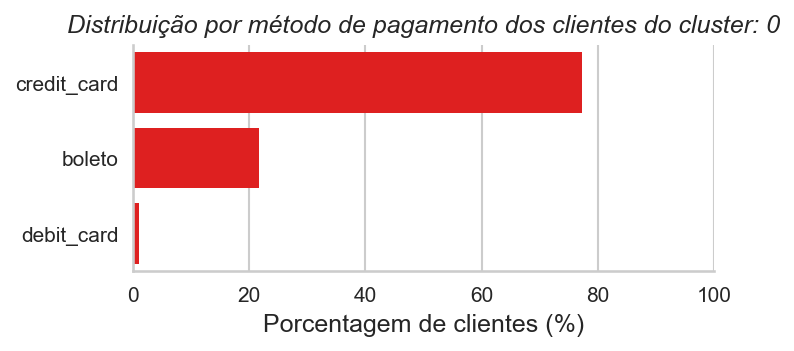

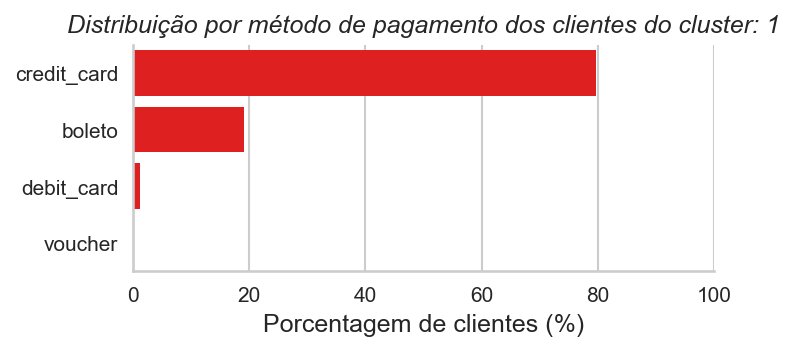

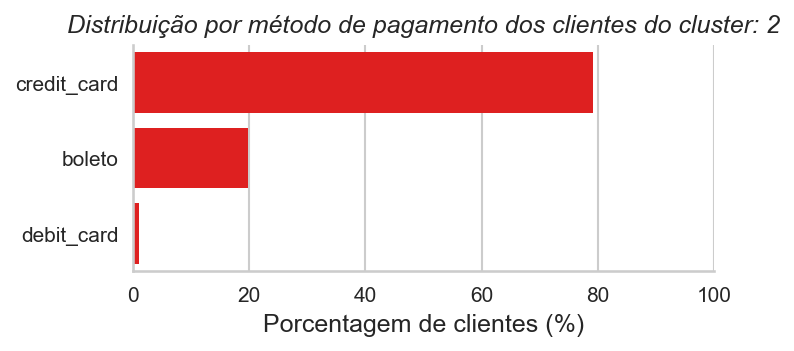

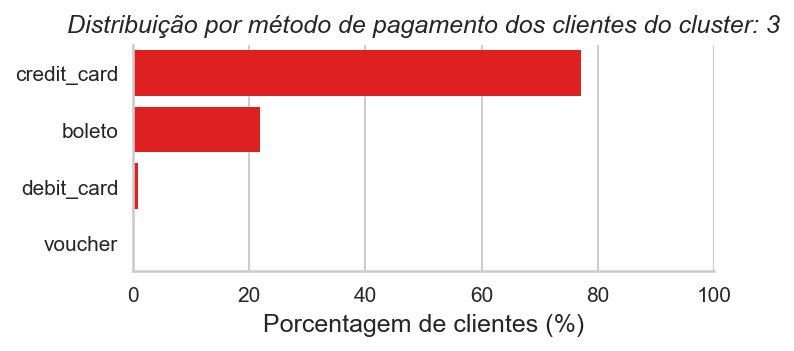

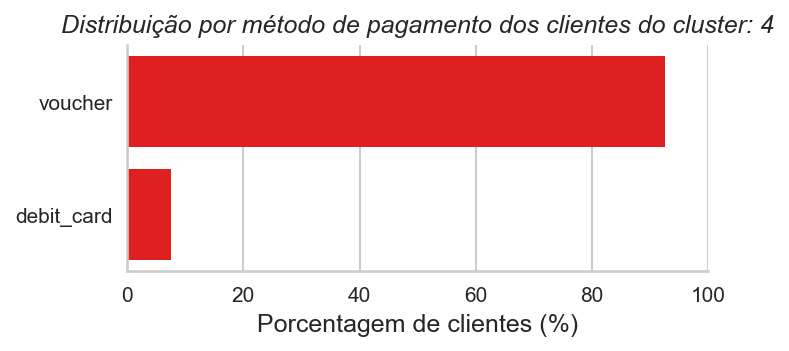

In [117]:
plot_clusters('payment_type', title='Distribuição por método de pagamento dos clientes do')

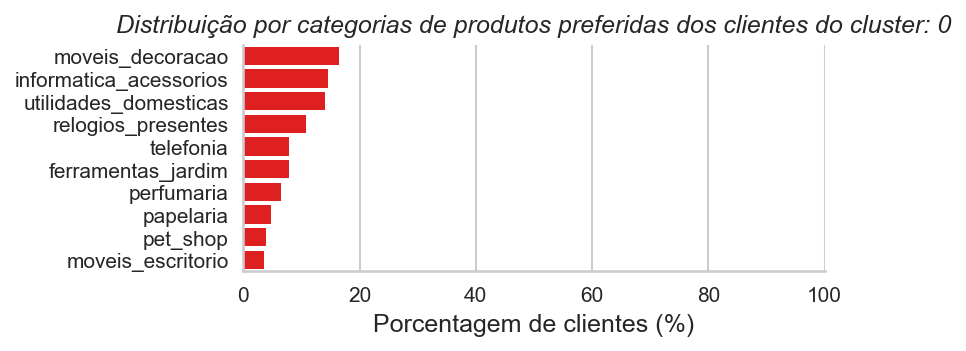

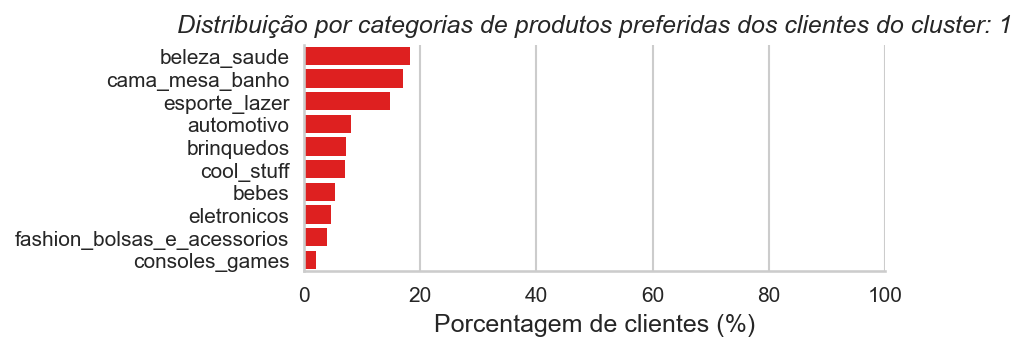

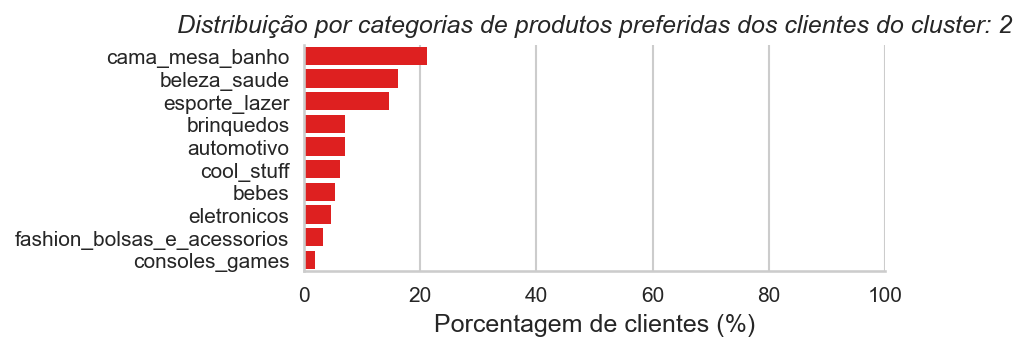

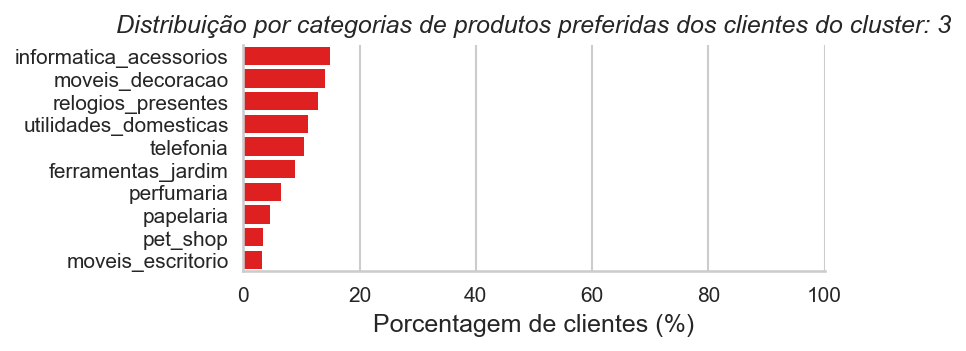

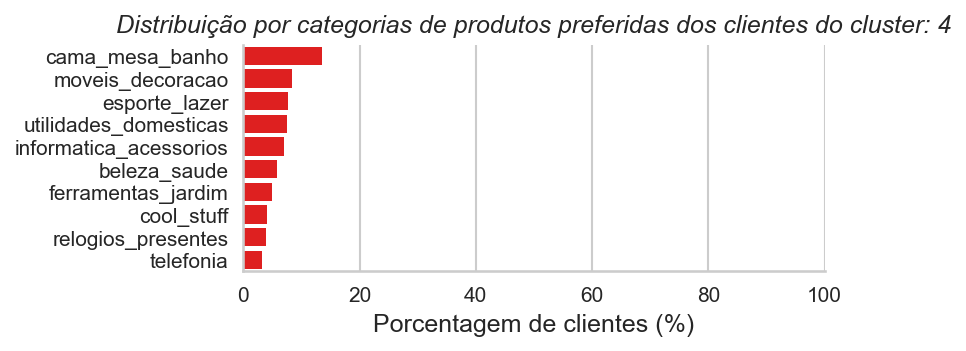

In [118]:
plot_clusters('product_category_name', title='Distribuição por categorias de produtos preferidas dos clientes do')

In [119]:
estados_regioes = {'Norte':['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
                   'Nordeste':['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
                   'Centro-Oeste':['DF', 'GO', 'MS', 'MT'],
                   'Sudeste':['ES', 'MG', 'RJ', 'SP',],
                   'Sul':['PR', 'RS', 'SC']}

regioes_clientes = list(range(len(clientes_kmeans_scaled)))

for i in range(len(clientes_kmeans_scaled)):
    for regiao in estados_regioes.keys():
        if clientes_kmeans_scaled['customer_state'].values[i] in estados_regioes[regiao]:
            regioes_clientes[i] = regiao

clientes_kmeans_scaled['regiao'] = regioes_clientes
clientes_kmeans_scaled

,customer_state,payment_type,payment_value,product_category_name,cluster,regiao
0,SP,credit_card,114.74,brinquedos,2,Sudeste
1,MG,credit_card,67.41,beleza_saude,1,Sudeste
2,ES,credit_card,195.42,bebes,1,Sudeste
3,MG,boleto,179.35,cool_stuff,1,Sudeste
4,SP,boleto,107.01,cama_mesa_banho,2,Sudeste
...,...,...,...,...,...,...
115884,RS,voucher,71.23,cama_mesa_banho,4,Sul
115885,RJ,credit_card,63.13,telefonia,0,Sudeste
115886,SP,credit_card,214.13,cama_mesa_banho,2,Sudeste
115887,MG,credit_card,45.50,moveis_decoracao,3,Sudeste


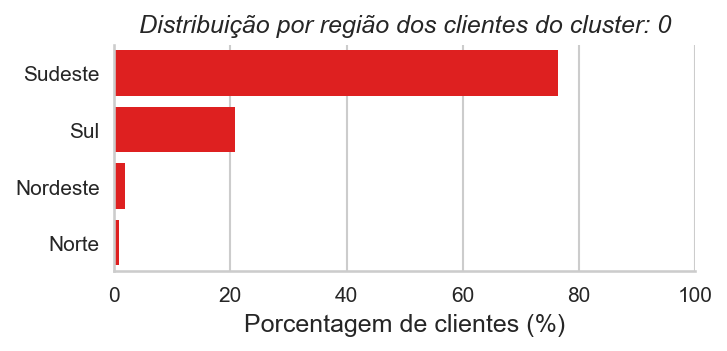

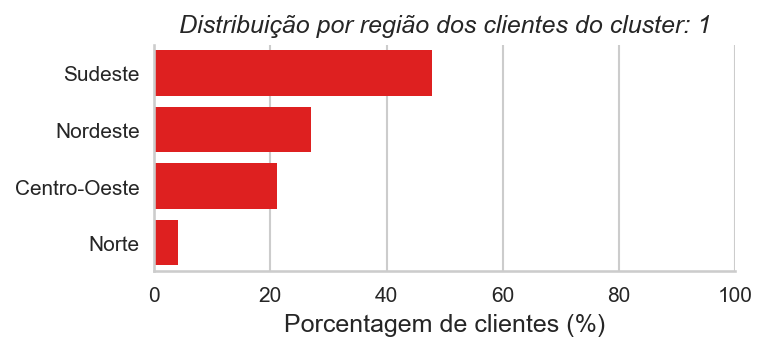

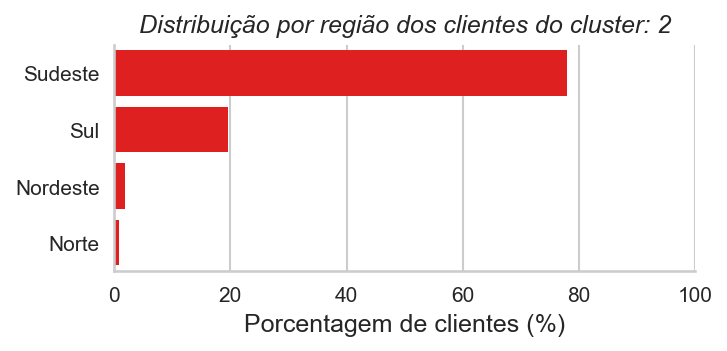

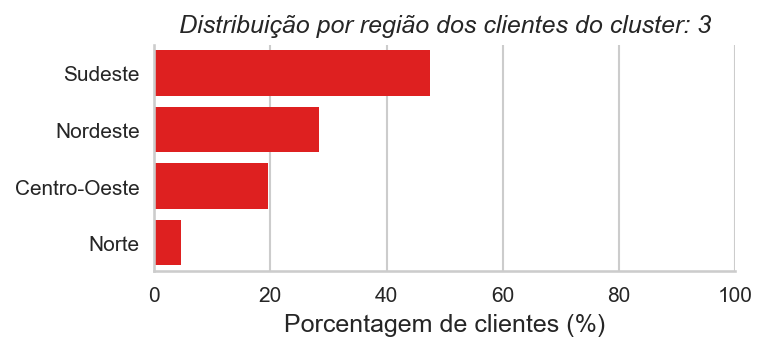

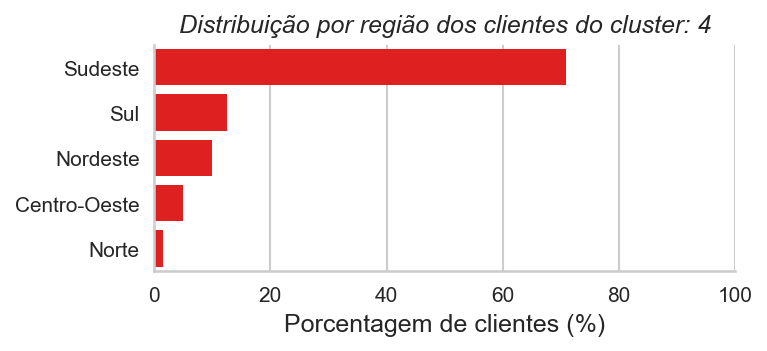

In [120]:
plot_clusters('regiao', title='Distribuição por região dos clientes do')

In [121]:
clientes_kmeans_scaled.cluster.value_counts()

2    40796
0    36890
1    16365
3    15188
4     6650
Name: cluster, dtype: int64

In [122]:
clientes_kmeans_scaled.cluster.value_counts(normalize=True) * 100

2    35.202651
0    31.832184
1    14.121271
3    13.105644
4     5.738250
Name: cluster, dtype: float64

## Quais grupos de clientes poderiam receber alguma ação de investimento de acordo com sua performance de vendas? Por quê?

| Cluster | Gastos médios R$ | Principais estados | Principais Regiões | Principais método de pagamento | Principais categorias de produtos | Nº de clientes | Porcentagem dos clientes |
| -- | -- | -- | -- | -- | -- | -- | -- |
| 0 | 184.07 | SP, RJ, RS, PR, SC | Sudeste, Sul | Cartão de crédito, Boleto | Móveis e decoração, Informática e acessórios, Utilidades domésticas | 36890 | 31.83 % |
| 1 | 188.71 | MG, BA, GO, DF, ES | Sudeste, Nordeste, Centro-Oeste | Cartão de crédito, Boleto | Beleza e saúde, Cama mesa e banho, Esporte e lazer | 16365 | 14.12% |
| 2 | 160.58 | SP, RJ, RS, PR, SC | Sudeste, Sul | Cartão de crédito, Boleto | Cama mesa e banho, Beleza e saúde, Esporte e lazer | 40796 | 35.20% |
| 3 | 208.10 | MG, BA, GO, DF, ES | Sudeste, Nordeste, Centro-Oeste | Cartão de crédito, Boleto | Informática e acessórios, Móveis e decoração, Relógios e presentes | 15188 | 13,11% |
| 4 | 69.69 | SP, RJ, MG, RS, PR  | Sudeste | Voucher, Débito | Cama mesa e banho, Móveis e decoração, Esporte e lazer | 6650 | 5,74% |

O grupo do cluster 0 parece ser um grupo potencial para ações de investimento. Este é um dos grupos com a maior quantidade de clientes (31,83% do total de clientes da amostra). O gasto médio dos clientes deste cluster é o terceiro maior (R$ 184,07 por cliente), o cluster com clientes de maior gasto médio é o 3 (R$ 208,10 por cliente) porém é um dos com o menor quantitativo de clientes (13.11% do total de clientes da amosra). Os clientes do cluster 0 concentram-se nas regiões Sul e Sudeste nos estados mais populosos e próximos da maioria dos vendedores o que diminui o custo e o tempo das entregas. Este grupo demonstra ter interesse maior em artigos do lar.

## Modelo de classificação para o cálculo da probabilidade de um determinado cliente pertencer a um dos grupos.

Separação das variáveis preditoras e alvo.

In [123]:
X = clientes_kmeans_coded.drop('cluster', axis=1)
y = clientes_kmeans_coded['cluster']

Separação dos grupos de treino e teste

In [124]:
np.random.seed(101)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Treinamento do modelo de classificação (Random Forest) utilizando validação cruzada.

In [125]:
cv = StratifiedKFold(n_splits = 7, shuffle = True)
rfc = RandomForestClassifier()
y_prob_rfc = cross_val_predict(rfc, X_train, y_train, cv = cv, method = 'predict_proba')
y_scores = y_prob_rfc[:, 1] # Resultados de treinamento

Cálculo da curva ROC para os resultados de treinamento usando validação cruzada.

In [126]:
fpr_classes, tpr_classes, threshold_classes = [], [], []
areas = []
for classe in range(5):
    y_t1 = [1 if classe == i else 0 for i in y_train]
    fpr, tpr, thresholds = roc_curve(y_t1, y_prob_rfc[:, classe])
    fpr_classes.append(fpr)
    tpr_classes.append(tpr)
    threshold_classes.append(thresholds)
    areas.append(roc_auc_score(y_t1, y_prob_rfc[:, classe]))

print('Área sob a curva ROC = {:.2f}'.format(roc_auc_score(y_train, y_prob_rfc, multi_class='ovr')))

Área sob a curva ROC = 1.00


Plot do gráfico da curva ROC para a predição de cada cluster.

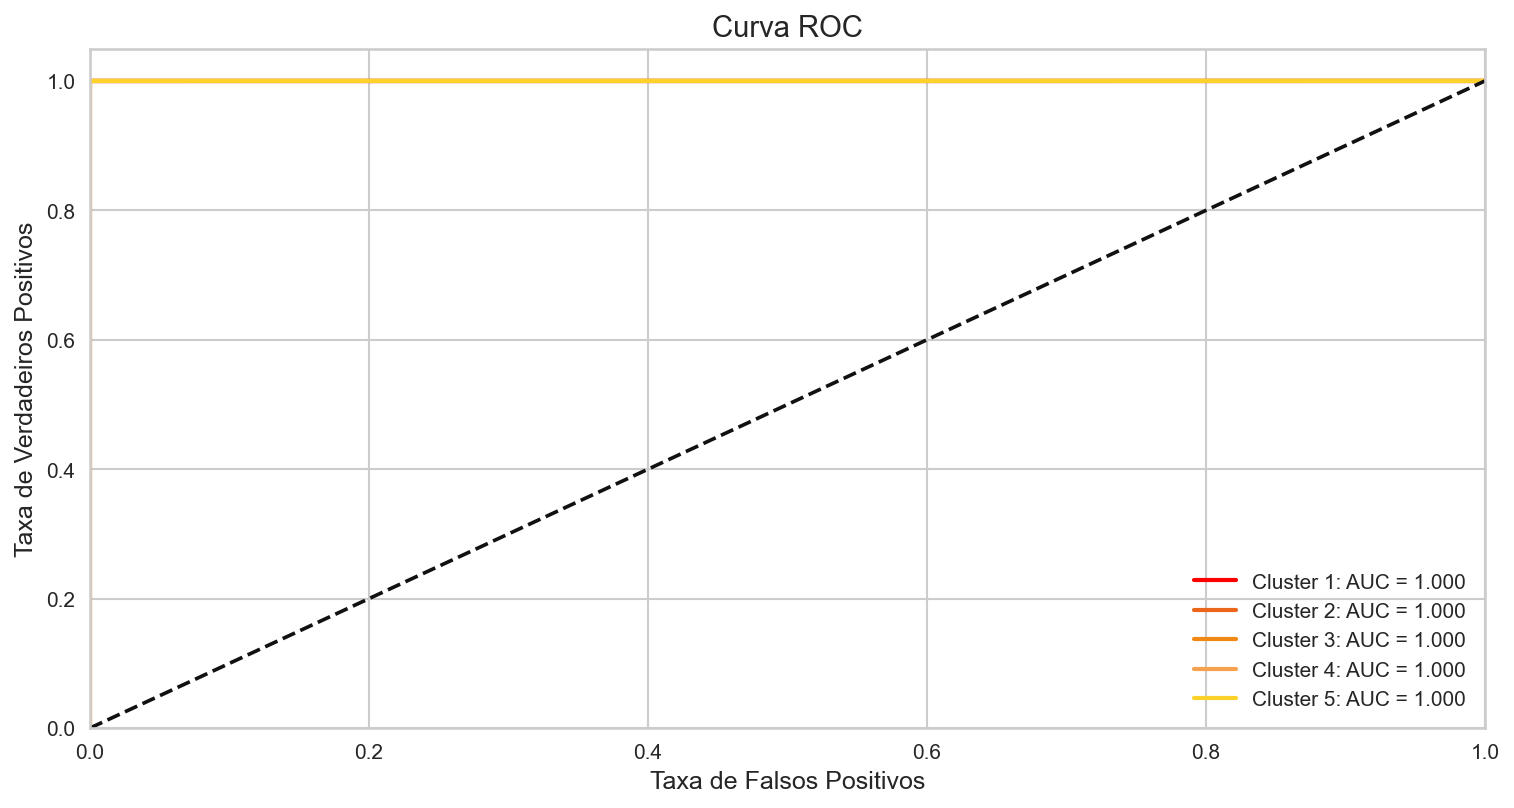

In [127]:
fig, ax = plt.subplots(figsize = (12, 6), dpi=150)
colors = ['#fe0000', '#eb661b', '#f18813', '#f6a150', '#fcd12a']
for i in range(5):
    area = areas[i].round(3)
    plt.plot(fpr_classes[i], tpr_classes[i], linewidth=2, label=f'Cluster {i+1}: AUC = {area:.3f}', color=colors[i])
plt.plot([0, 1], [0, 1], 'k--')
fig.fontsize=12
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC', fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.legend()
plt.show()

Treinamento e teste do modelo para o conjunto de teste.

In [128]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)
y_predito = rfc.predict(X_test)
print('Área sob a curva ROC = {:.5f}'.format(roc_auc_score(y_test, y_pred, multi_class='ovr')))
print('Acurácia do modelo = {:.5f}'.format(accuracy_score(y_test, y_predito)))

Área sob a curva ROC = 1.00000
Acurácia do modelo = 0.99986


Os resultados mostram que a classificação de um determinado cliente, de acordo com os critérios utilizados, em algum dos clusters divididos é quase perfeita. Os altos valores de acurácia e ROC são justificados pelo fato de a divisão dos clusters ter sido feita utilizando um modelo matemático. Assim, a divisão dos clusters foi bem ajustada e por consequência o modelo de classificação teve um desempenho tão elevado.

## Análise da série temporal de volume de compras mensal dos clientes .

Série temporal das vendas diárias.

In [129]:
vendas_time_series = vendas[['order_approved_at', 'payment_value']]
vendas_time_series['order_approved_at'] = pd.to_datetime(vendas_time_series['order_approved_at'])
vendas_time_series.set_index('order_approved_at', inplace=True)
vendas_time_series.head()

C:\Users\duart\AppData\Local\Temp/ipykernel_27504/3455571633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendas_time_series['order_approved_at'] = pd.to_datetime(vendas_time_series['order_approved_at'])


,payment_value
order_approved_at,
2018-05-20 18:58:59,120.24
2017-12-12 19:32:19,143.83
2017-12-22 17:31:27,242.10
2018-08-10 13:35:21,78.50
2018-08-01 22:15:19,78.50


Série mensal de vendas

In [130]:
vendas_mensais = vendas_time_series.resample('M').sum() / 1_000_000
vendas_mensais

,payment_value
order_approved_at,
2016-10-31,0.074262
2016-11-30,0.000000
2016-12-31,0.000020
2017-01-31,0.179456
2017-02-28,0.342237
2017-03-31,0.526772
2017-04-30,0.501520
2017-05-31,0.724199
2017-06-30,0.607830


Os três primeiros meses da série e o último mês da série tem valores bem diferentes dos demais meses. Possívelmente esta amostra não contém todos os registros de vendas nesses meses. Assim, tais registros serão removidos da análise.

In [131]:
vendas_mensais = vendas_mensais.iloc[3:-1]

Gráfico a série de vendas mensais.

Text(0.5, 1.0, 'Vendas mensais em milhões de reais')

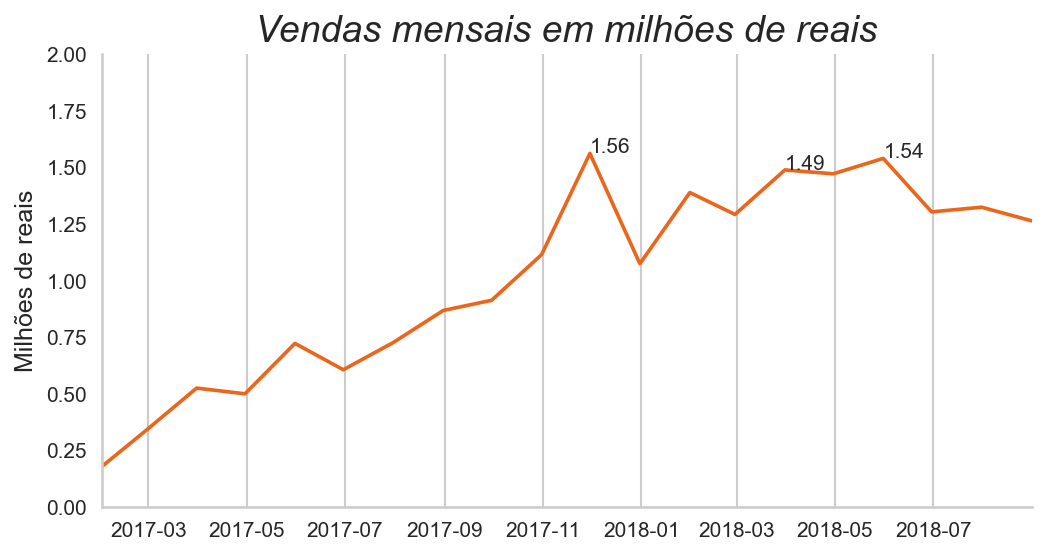

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
sns.lineplot(data=vendas_mensais, y='payment_value', x=vendas_mensais.index, color='#eb661b', ax=ax)
plt.ylim(0, 2)
plt.xlabel('')
plt.ylabel('Milhões de reais', fontsize=12)
plt.xlim(vendas_mensais.index[0], vendas_mensais.index[-1])
top_3 = vendas_mensais.sort_values(by='payment_value', ascending=False)[:3]

for i in range(3):
    plt.text(top_3.index[i], top_3.payment_value.values[i], top_3.payment_value.values[i].round(2))

ax.spines[['top', 'right']].set_visible(False)
plt.grid(axis='y')
plt.title('Vendas mensais em milhões de reais', fontsize=18, style='italic')

A série mostra que o volume de vendas apresentou um tendência de aumento até o mês de junho de 2018 a partir deste momento, aparentemente, houve diminuição no volume de vendas. Os meses de maiores vendas foram dezembro de 2017 (RS 1.56 milhões), junho de 2018 (RS 1.54 milhões) e abril de 2018 (RS 1.49 milhões).

## Quais as considerações da série temporal? Tendência? Ciclo? Efeitos Aleatórios? Há Sazonalidades?

Decomposição da série temporal: tendência, sazonalidade e ruído

<Figure size 1200x600 with 0 Axes>

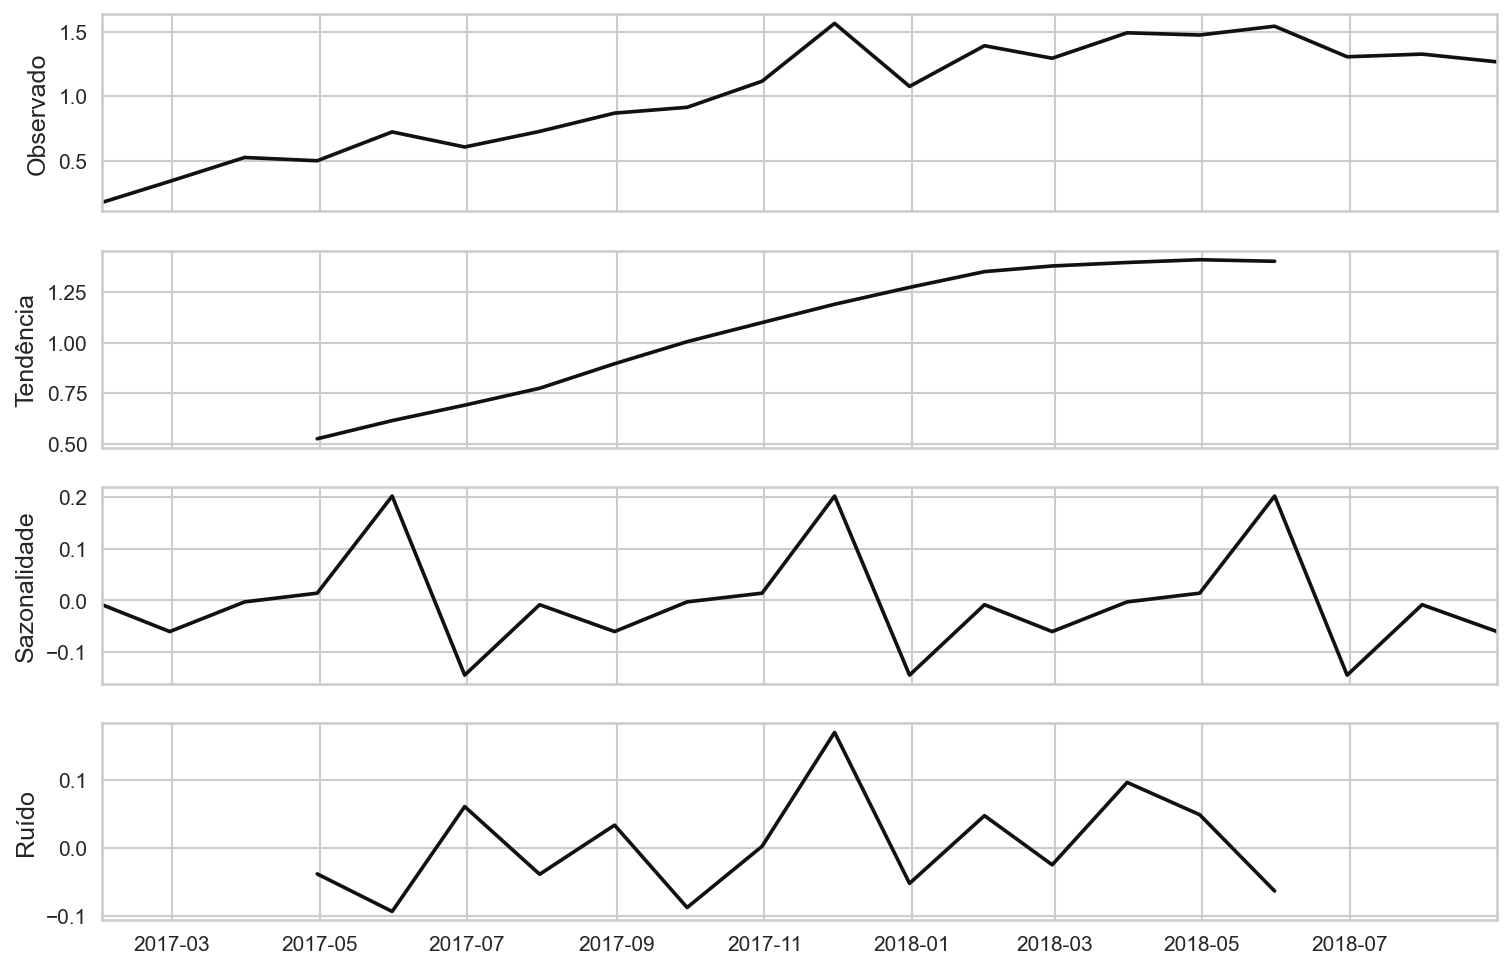

In [133]:
plt.figure(figsize=(12, 6), dpi=100)
result= seasonal_decompose(vendas_mensais.payment_value, model='additive', period=6)
tendencia = result.trend
sazonalidade = result.seasonal
observado = result.observed
ruido = result.resid

fig, axes = plt.subplots(4, 1, figsize=(12, 8), dpi=150, sharex=True)
fig.fontsize=12
axes[0].plot(observado, color='k')
axes[1].plot(tendencia, color='k',)
axes[2].plot(sazonalidade, color='k')
axes[3].plot(ruido, color='k')
axes[0].set_ylabel('Observado', fontsize=12)
axes[1].set_ylabel('Tendência', fontsize=12)
axes[2].set_ylabel('Sazonalidade', fontsize=12)
axes[3].set_ylabel('Ruído', fontsize=12)
plt.xlim(vendas_mensais.index[0], vendas_mensais.index[-1])
plt.show()

A análise de tendência mostra uma tendência de aumento até o mês de fevereiro de 2018 a partir de então há uma estabilização e a não há sinal significante de tendência.

Quanto a sazonalidade é observado um ciclo semestral na série com picos de vendas ocorrendo nos meses de maio e dezembro. Maio é o mês das mães o que pode impulsionar a vendas já que a maioria dos produtos vendidos é relacionado a utilidades dos lar que são geralmente os presentes mais comprados na época. E dezembro é um mês que geralmente impulsiona a vendas já que há maior circulação de dinheiro devido ao pagamento dos 13º salário e as festividades de fim de ano.

Um ruído também foi apresentado na série. Porém, com baixa variabilidade.

## Há algum fator de regionalidade que influencia o volume de vendas?

In [134]:
clientes_kmeans_scaled

,customer_state,payment_type,payment_value,product_category_name,cluster,regiao
0,SP,credit_card,114.74,brinquedos,2,Sudeste
1,MG,credit_card,67.41,beleza_saude,1,Sudeste
2,ES,credit_card,195.42,bebes,1,Sudeste
3,MG,boleto,179.35,cool_stuff,1,Sudeste
4,SP,boleto,107.01,cama_mesa_banho,2,Sudeste
...,...,...,...,...,...,...
115884,RS,voucher,71.23,cama_mesa_banho,4,Sul
115885,RJ,credit_card,63.13,telefonia,0,Sudeste
115886,SP,credit_card,214.13,cama_mesa_banho,2,Sudeste
115887,MG,credit_card,45.50,moveis_decoracao,3,Sudeste


In [135]:
clientes_por_estado = clientes_kmeans_scaled.groupby('customer_state')['payment_type'].count().to_frame()
vendas_por_estado = clientes_kmeans_scaled.groupby('customer_state')['payment_value'].sum().to_frame()
vendas_clientes_estado = clientes_por_estado.join(vendas_por_estado)
vendas_clientes_estado['gasto_medio'] = vendas_clientes_estado['payment_value'] / vendas_clientes_estado['payment_type']
vendas_clientes_estado.columns = ['total_clientes', 'total_pago', 'valor_por_cliente']
vendas_clientes_estado.sort_values(by='valor_por_cliente', ascending=False).head(10)

,total_clientes,total_pago,valor_por_cliente
customer_state,,,
PB,629,177666.93,282.459348
AC,93,24857.52,267.285161
AP,84,21642.70,257.651190
AL,454,110593.98,243.599075
RR,50,12160.39,243.207800
PI,566,135940.77,240.178039
MA,832,196396.63,236.053642
RO,280,64967.06,232.025214
MT,1113,255553.57,229.607880


In [136]:
vendas_clientes_estado.sort_values(by='total_pago', ascending=False).head(10)

,total_clientes,total_pago,valor_por_cliente
customer_state,,,
SP,48846,7501778.00,153.580191
RJ,15089,2736100.98,181.330836
MG,13452,2302454.92,171.160788
RS,6384,1127983.81,176.689193
PR,5882,1053724.99,179.143997
BA,3975,786169.98,197.778611
SC,4237,777467.95,183.494914
GO,2376,503590.10,211.948695
DF,2440,429150.39,175.881307


Os estados com maiores volumes de compras são SP, RJ e MG. Tais estados também são os maiores do Brasil em termos de população, assim, já seria esperado que tais estados ficassem nas primeiras posições quanto ao número de clientes e volume de compras.

Já, considerando-se os gastos médios por cliente, destacam-se os estados de PB (RS 282,46 por cliente), AC (RS 267,29 por cliente) e AP (RS 257,65 por cliente). Os gastos médios por cliente dos estados das regiões Norte e Nordeste mostra-se superior do que o gasto médio para os estados das demais regiões. É importante considerar que neste cálculo o frete foi incluído no preço final do produto o que pode contribuir para o aumento do gasto médio dos clientes.

## Modelo de previsão do Volume de Demandas para o ano de 2022.

In [137]:
y = vendas_mensais.payment_value.copy()
y.index = y.index.to_period("M")

In [138]:
y_train = y[:14]  
y_test = y[14:]  

Ajuste do modelo para os períodos de treino e teste

MAP médio: 0.27629021649836033
RMSE médio: 0.37381577739269073


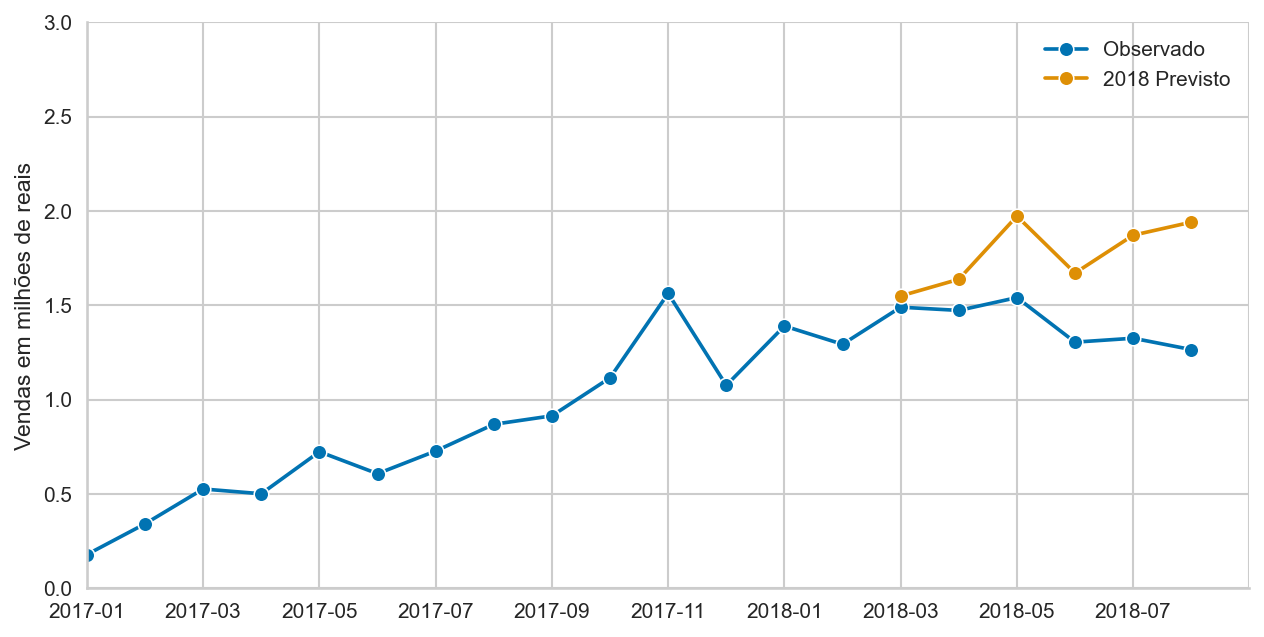

In [139]:
fh = np.arange(len(y_test)) + 1
modelo_preditor = ExponentialSmoothing(trend="add", seasonal="additive", sp=6)
modelo_preditor.fit(y_train)
y_last = modelo_preditor.predict(fh)
print("MAP médio:", mean_absolute_percentage_error(y_test, y_last))
print("RMSE médio:", mean_absolute_error(y_test, y_last))

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
fig.fontsize=12
plot_series(y, y_last, labels=["Observado", "2018 Previsto"], ax=ax)
plt.xlim(0, len(y))
plt.ylim(0, 3)
plt.ylabel('Vendas em milhões de reais')
ax.spines[['top', 'right']].set_visible(False)

Erro médio mensal

In [140]:
(y_last - y_test) / y_test

2018-03    0.040005
2018-04    0.111925
2018-05    0.280112
2018-06    0.280563
2018-07    0.411771
2018-08    0.533365
Freq: M, dtype: float64

O modelo apresenta um bom ajuste até o segundo mês de previsão. Com significativa deterioração para horizontes de previsão maior.

Previsões para 2018

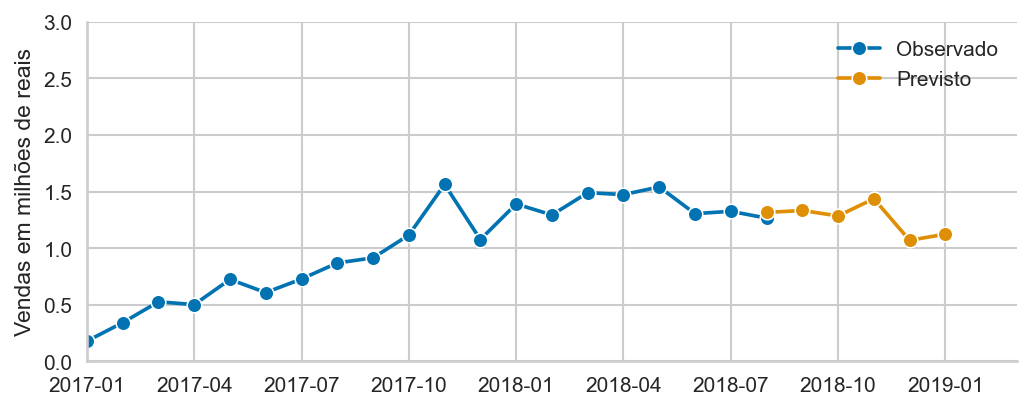

In [141]:
fh = np.arange(6) 
modelo_preditor = ExponentialSmoothing(trend="add", seasonal="additive", sp=6)
modelo_preditor.fit(y)
y_pred = modelo_preditor.predict(fh)
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=150)
fig.fontsize=12
plot_series(y, y_pred, labels=["Observado", "Previsto"], ax=ax)
plt.xlim(0, len(y)+6)
plt.ylim(0, 3)
plt.ylabel('Vendas em milhões de reais')
ax.spines[['top', 'right']].set_visible(False)

A projeção para o período agosto de 2018 a janeiro de 2019 aponrta para certa estabilidade no total de vendas até o mês de outubro de 2018 com declínio nos meses seguintes.